In [3]:
import refinitiv.data as rd
import configparser as cp
import eikon as ek  # the Eikon Python wrapper package
import pandas as pd
import numpy as np
import cufflinks as cf  # Cufflinks
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from dateutil.relativedelta import relativedelta
import talib as ta

/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_42148/606155150.py:10: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [1]:
!

/Users/neftalivaldez/app/tec/tec_finanzas_2023_agosto


In [4]:
cfg = cp.ConfigParser()
cfg.read('../refinitiv.cfg')
ek.set_app_key(cfg['eikon']['app_id'])

In [5]:
df = ek.get_data('LP68167376', ['TR.FundRollingPerformance.date',
                           'TR.FundRollingPerformance.value'],
            {'Curn':'SGD','RollTimeFrame':'1Y','Interval':'M'})

In [6]:
df

(    Instrument                  Date  Rolling Performance
 0   LP68167376  2022-09-30T00:00:00Z            -9.894127
 1   LP68167376  2022-10-28T00:00:00Z             8.064516
 2   LP68167376  2022-11-25T00:00:00Z             3.385786
 3   LP68167376  2022-12-30T00:00:00Z            -2.062878
 4   LP68167376  2023-01-27T00:00:00Z             3.088008
 5   LP68167376  2023-02-24T00:00:00Z            -2.928429
 6   LP68167376  2023-03-31T00:00:00Z             2.601507
 7   LP68167376  2023-04-28T00:00:00Z             2.902637
 8   LP68167376  2023-05-26T00:00:00Z            -0.395452
 9   LP68167376  2023-06-30T00:00:00Z             3.510843
 10  LP68167376  2023-07-28T00:00:00Z             1.543656
 11  LP68167376  2023-08-25T00:00:00Z            -2.276076,
 None)

In [9]:
def SMA(close,sPeriod,lPeriod):
    shortSMA = ta.SMA(close,sPeriod)
    longSMA = ta.SMA(close,lPeriod)
    smaSell = ((shortSMA <= longSMA) & (shortSMA.shift(1) >= longSMA.shift(1)))
    smaBuy = ((shortSMA >= longSMA) & (shortSMA.shift(1) <= longSMA.shift(1)))
    return smaSell,smaBuy,shortSMA,longSMA

In [13]:
def RSI(close,timePeriod):
    rsi = ta.RSI(close,timePeriod)
    rsiSell = (rsi>70) & (rsi.shift(1)<=70)
    rsiBuy = (rsi<30) & (rsi.shift(1)>=30)
    return rsiSell,rsiBuy, rsi

In [14]:
def Stoch(close,high,low):
    slowk, slowd = ta.STOCH(high, low, close)
    stochSell = ((slowk < slowd) & (slowk.shift(1) > slowd.shift(1))) & (slowd > 80)
    stochBuy = ((slowk > slowd) & (slowk.shift(1) < slowd.shift(1))) & (slowd < 20)
    return stochSell,stochBuy, slowk,slowd

In [15]:
# Key code snippets - see Github for full source
def sendSignaltoChatBot(myRIC, signalTime, indicators):
    indicatorList = ','.join(indicators.values)
    message = f"TA signal(s) Generated : {indicatorList} at {signalTime} for {myRIC}"
    # Connect, login and send message to chatbot
    rdp_token = RDPTokenManagement( bot_username, bot_password, app_key)
    access_token = cdr.authen_rdp(rdp_token)
    if access_token:
        # Join associated Chatroom
        joined_rooms = cdr.join_chatroom(access_token, chatroom_id)
        if joined_rooms:
            cdr.post_message_to_chatroom(access_token, joined_rooms, chatroom_id, message)

In [16]:
def runAllTA(myRIC, data):
    price = data['CLOSE']
    high = data['HIGH']
    low = data['LOW']
    # Simple Moving Average calcs
    smaSell,smaBuy,shortSMA,longSMA = SMA(price,shortPeriod,longPeriod)
    # Do the RSI calcs
    rsiSell,rsiBuy,rsi = RSI(price,shortPeriod)
    # and now the stochastics
    stochSell,stochBuy,slowk,slowd = Stoch(price, high, low)    
    # Now collect buy and sell Signal timestamps into a single df
    sigTimeStamps = pd.concat([smaSell, smaBuy, stochSell, stochBuy, rsiSell, rsiBuy],axis=1)
    sigTimeStamps.columns=['SMA Sell','SMA Buy','Stoch Sell','Stoch Buy','RSI Sell','RSI Buy']
    signals = sigTimeStamps.loc[sigTimeStamps['SMA Sell'] | sigTimeStamps['Stoch Sell'] |
                        sigTimeStamps['RSI Sell'] | sigTimeStamps['SMA Buy'] |
                        sigTimeStamps['Stoch Buy'] | sigTimeStamps['RSI Buy']]
   
    # Compare final signal Timestamp with latest data TimeStamp
    if (data.index[-1]==signals.index[-1]):
        final = signals.iloc[-1]
        # filter out the signals set to True and send to ChatBot
        signal = final.loc[final]
        signalTime = signal.name.strftime("%Y-%m-%dT%H:%M:%S")
        indicators = signal.loc[signal].index
        sendSignaltoChatBot(myRIC, signalTime, indicators)

In [33]:
# Calculate Start and End time for our historical data request window
def startEnd(interval):
    end = dt.datetime.now()
    start = {
      'minute': lambda end: end - relativedelta(days=5),
      'hour': lambda end: end - relativedelta(months=2),
      'daily': lambda end: end - relativedelta(years=2),
      'weekly': lambda end: end - relativedelta(years=5),
      'monthly': lambda end: end - relativedelta(years=10),
    }[interval](end)
    return start.strftime("%Y-%m-%dT%H:%M:%S"),end.strftime("%Y-%m-%dT%H:%M:%S")

In [103]:
# As per before, key code snips only...
# Use a formatter to remove weekends from date axis
# to smooth out the line.
class MyFormatter():
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt
    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(round(x))
        if ind>=len(self.dates) or ind<0: return ''
        return self.dates[ind].strftime(self.fmt)
# Plot the Close price and short and long Simple Moving Averages
def plotSMAs(ric,close,sma14,sma200,sell,buy):
    x = close.index
    plt.rcParams["figure.figsize"] = (28,8)
    fig, ax = plt.subplots(facecolor='0.25')
    ax.plot(np.arange(len(x)),close, label='Close',color='y')
    ax.plot(np.arange(len(x)),sma14,label="SMA 14", color='g')
    ax.plot(np.arange(len(x)),sma200,label="SMA 200", color='tab:purple')
    plt.show()
# Plot the Close price in the top chart and RSI in the lower chart
def plotRSI(ric,close,rsi):
    x = close.index
    plt.rcParams["figure.figsize"] = (28,12)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.subplot(211)
    plt.plot(np.arange(len(x)),rsi,label="RSI", color='g')
    #plt.show()
    # Closing price chart
    plt.subplot(212)
    # make a plot with different y-axis using second axis object
    plt.plot(np.arange(len(close.index)), close, color='y')
    plt.show()
    
    
# Plot Close price in top chart and in the slowk + slowd lines in lower chart
def plotStoch(ric,close,slowK,slowD):
    plt.rcParams["figure.figsize"] = (28,12)
    fig = plt.figure(facecolor='0.25')
    x = close.index
    plt.rcParams["figure.figsize"] = (28,8)
    fig, ax = plt.subplots(facecolor='0.25')
    ax.plot(np.arange(len(slowk.index)), slowk.values,label="Slow K",color='m')
    ax.plot(np.arange(len(slowk.index)), slowd.values,label="Slow D",color='g')
    plt.axhline(y=80, color='w',linestyle='--')
    plt.axhline(y=20, color='w',linestyle='--')
    # Closing price chart
    axc=ax.twinx()
    # make a plot with different y-axis using second axis object
    axc.plot(np.arange(len(close.index)), close, color='y')
    plt.show()

In [56]:
myInterval = 'daily' # 'minute', 'hour', 'daily', 'weekly', 'monthly'
myStart, myEnd = startEnd(myInterval)
#timestampLen = timeStampLength(myInterval)
print(f'Interval {myInterval} from {myStart} to {myEnd}: Timestamp Length')
#: Timestamp Length {timestampLen}')
shortPeriod = 14
longPeriod = 200
basket={}
# Do we want to plot charts?
plotCharts = True
# Dataframe display setting
pd.set_option("display.max_rows", 999)
#pd.set_option("precision", 3)

Interval daily from 2021-09-01T13:29:22 to 2023-09-01T13:29:22: Timestamp Length


In [57]:
outputDF = pd.DataFrame(columns=['RIC','Name','ISIN','Close','Periodicity','Intervals Up',
                                 'Intervals Down','Unchanged','1wk %ch','1M %ch','YTD %ch','6M %ch',
                                 '1yr %ch','SMA Sell','SMA Buy','Stoch Sell','Stoch Buy','RSI Sell', 'RSI Buy' ])
blankSignalCols = ['N/A']*6
blankNonSignalCols = [' ']*13

In [58]:
myISINs = [   
    'GB0002634946',
    'GB00B1YW4409'
]
myRICs = ek.get_symbology(myISINs, from_symbol_type='ISIN', to_symbol_type='RIC')


In [59]:
listRICs = list(myRICs.RIC)
pcts, err = ek.get_data(
    instruments = listRICs,
    fields = [
        'TR.CommonName',
        'TR.CLOSEPRICE',
        'TR.PricePctChgWTD',
        'TR.PricePctChgMTD',
        'TR.PricePctChgYTD',
        'TR.PricePctChg6M',
        'TR.PricePctChg1Y',
    ]
)
pcts.set_index('Instrument',inplace=True)


In [60]:
pcts

,Company Common Name,Close Price,WTD Price PCT Change,MTD Price PCT Change,YTD Price PCT Change,6-month Price PCT Change,1-year Price PCT Change
Instrument,,,,,,,
BAES.L,BAE Systems PLC,1007.5,1.623966,0.0,17.698598,11.375193,32.39159
III.L,3i Group PLC,1998.5,3.872141,0.250815,48.975028,22.083079,76.312307


In [61]:
for ISIN, symb in myRICs.iterrows():
    myRIC=symb['RIC']
    data = ek.get_timeseries(myRIC,  
        fields = ['CLOSE','HIGH','LOW'],
        start_date=myStart,  
        end_date=myEnd,
        interval = myInterval)  

    price = data['CLOSE']
    high = data['HIGH']
    low = data['LOW']

    basket[myRIC]=data # Save each instrument's raw data for later use

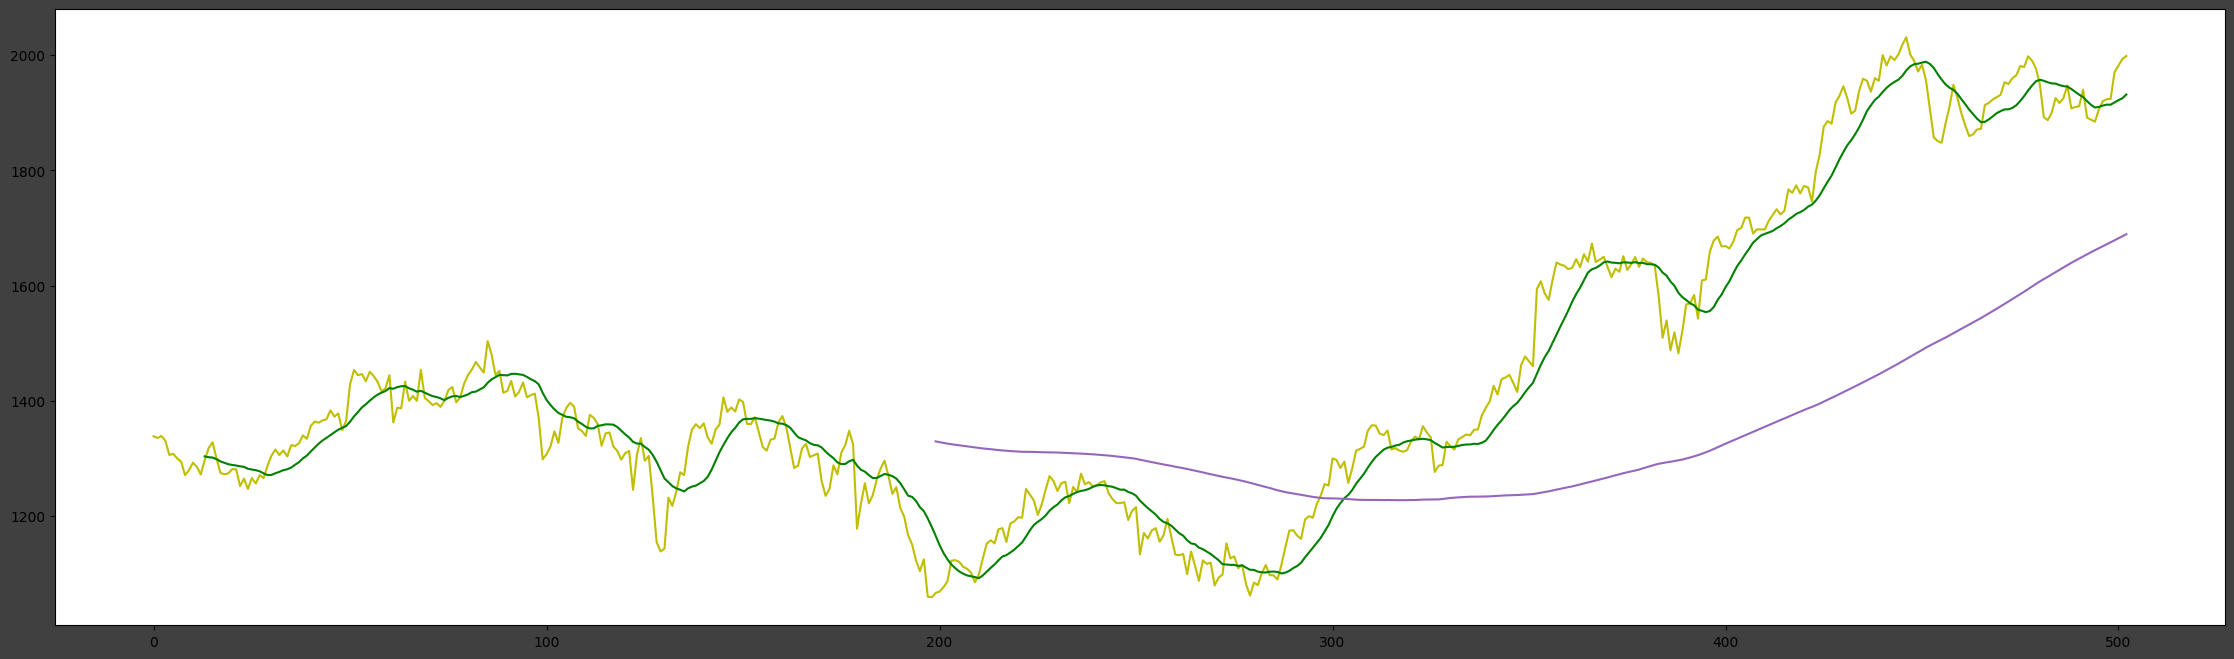

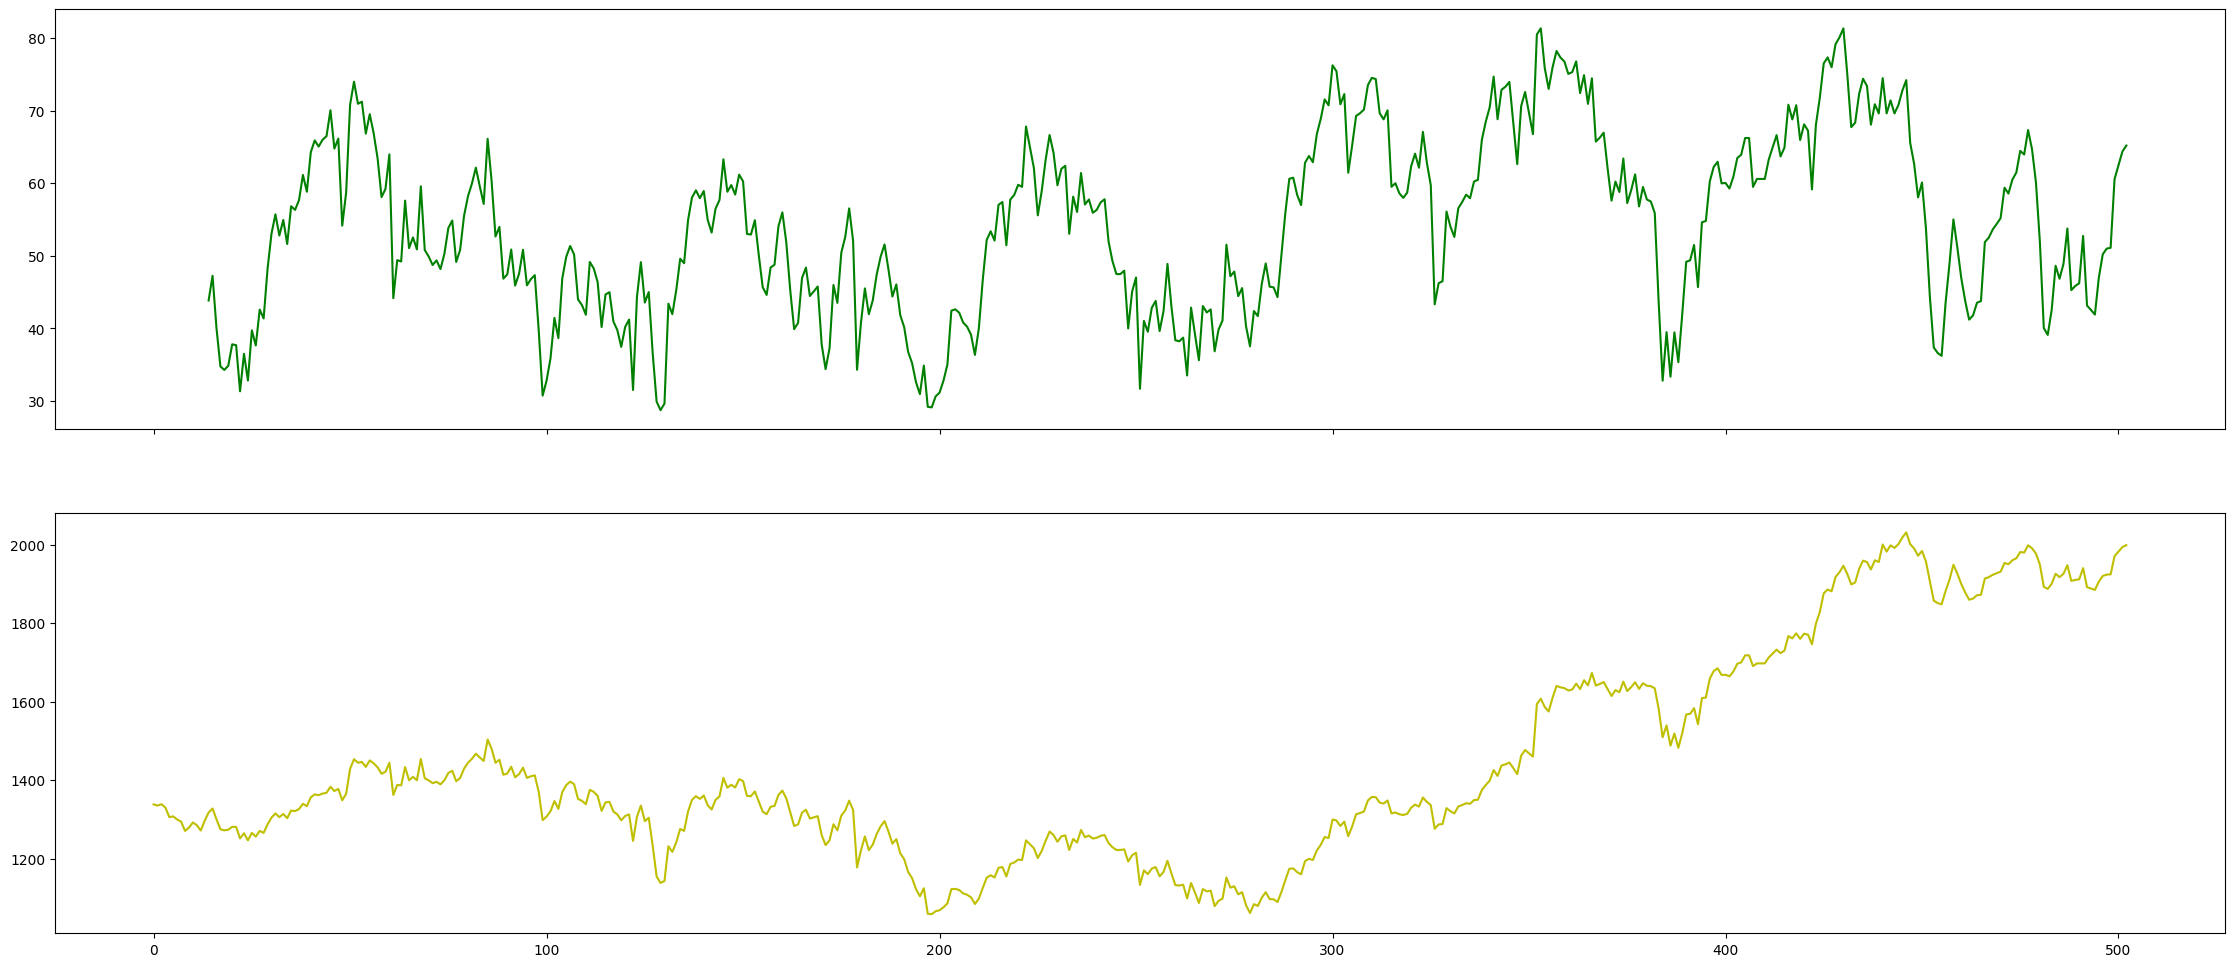

<Figure size 2800x1200 with 0 Axes>

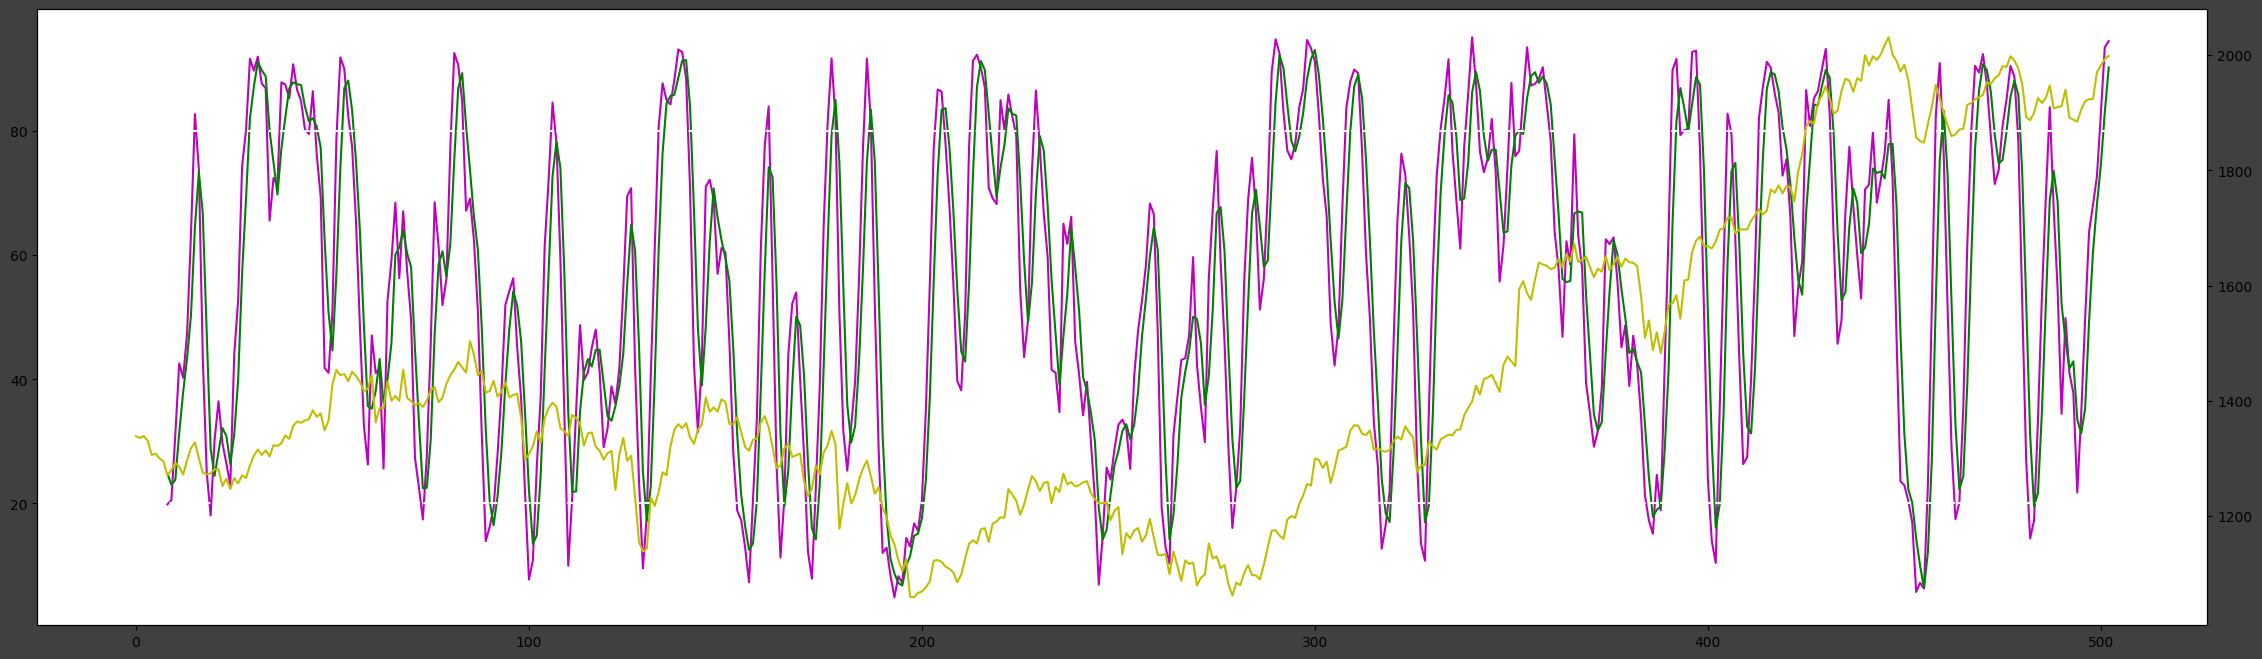

In [104]:
# Count Price Up, Down and No change
upCnt = (price < price.shift(1)).value_counts().loc[True]
downCnt = (price > price.shift(1)).value_counts().loc[True]
try:
    ncCnt = (price == price.shift(1)).value_counts().loc[True]
except KeyError as e:
    ncCnt = 0

# Do the Simple Moving Average calcs
smaSell,smaBuy,shortSMA,longSMA = SMA(price,shortPeriod,longPeriod)
if plotCharts:
    plotSMAs(myRIC,price,shortSMA,longSMA,smaSell,smaBuy)

# Do the RSI calcs
rsiSell,rsiBuy,rsi = RSI(price,shortPeriod)
if plotCharts:
    plotRSI(myRIC,price,rsi)

# Stochastic calcs
stochSell,stochBuy,slowk,slowd = Stoch(price, high, low)
if plotCharts:
    plotStoch(myRIC,price,slowk,slowd)

# Get the Percent Change data for thisRIC
pct = pcts.loc[myRIC]